## Science Frame Correction

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from astropy.io import fits
import pickle

science_list = np.genfromtxt('./group10_WASP-135_20190803/science/science.list', dtype=str)


### Testing the code on a subset of images
In lab we tested our reduction pipeline and tools only on a small subsample of images beacuse of reduced available space on the computer. Now we will use the full sample.

In [14]:
science_test_list = science_list[:30] #Nel caso volessimo ridurre basta selezionare solo alcune immagini di science list

### Data Reduction Steps
Science **data reduction** includes the following steps:
1. Multiplication by GAIN (as always)
2. Bias Subtraction
3. Division by flat

Therefore we have the following **error sources**:
1. Readout Noise
2. Bias Error
3. Flat Error
4. Photon Noise

In order to procede we load the necessary quantities.

In [15]:
# Prendiamo i dati salvati
median_bias = pickle.load(open("median_bias.p", "rb"))
median_normalized_flat = pickle.load(open("median_normalized_flat.p", "rb"))
median_normalized_flat_errors = pickle.load(open("median_normalized_flat_errors.p", "rb"))

# Prendiamo i dati rimanenti dai notebook 01 e 02
bias_std = 1.33 # [e] = photoelectrons
readout_noise = 7.10 # [e] = photoelectrons
gain = 1.91 #[e/ADU] from the header file

For the photon noise, we use the method we employed for the flat. The photon noise must be computed **after** removing the bias but **before** correcting for the flat field. In fact the error must be calculated on the actual number of photons received on the detector, not on the photons emitted by the source.

The error on the science_debiased is given by the sum in quadrature of the errors:

##### Debiased Error
$\sigma_{debiased} = \sqrt{\sigma_{rdn}^2 + \sigma_{bias}^2 + \sigma_{photon}^2}$

The photon noise follows a Poissonian distribution so it is given by the square root of the counts $\sqrt{\texttt{science\_debiased}}$:

$\sigma_{debiased} = \sqrt{\sigma_{rdn}^2 + \sigma_{bias}^2 + \texttt{science\_debiased}}$

##### Corrected Error
For science correction, the corrected intensity is given by:

$\text{science\_corrected} = \frac{\text{science\_debiased}}{\text{median\_normalized\_flat}}$

We apply the error propagation rule for division. If a quantity $z$ is given by the ratio of two variables $x$ and $y$,

$\frac{\sigma_z}{z} = \sqrt{\left(\frac{\sigma_x}{x}\right)^2 + \left(\frac{\sigma_y}{y}\right)^2}$

Applying this formula to our variables:

$\frac{\sigma_{\text{science\_corrected}}}{\text{science\_corrected}} =
\sqrt{\left(\frac{\sigma_{\text{science\_debiased}}}{\text{science\_debiased}}\right)^2 +
\left(\frac{\sigma_{\text{median\_normalized\_flat}}}{\text{median\_normalized\_flat}}\right)^2}$

Finally, multiplying both sides by $\text{science\_corrected}$, we obtain the final expression:

$\sigma_{\text{science\_corrected}} =
\text{science\_corrected} \times \sqrt{
\left(\frac{\sigma_{\text{science\_debiased}}}{\text{science\_debiased}}\right)^2 +
\left(\frac{\sigma_{\text{median\_normalized\_flat}}}{\text{median\_normalized\_flat}}\right)^2
}$




In [16]:
for science_name in science_list:
    """Load the science frames, multiply them by the gain, subtract the median_bias,
    divide by the flat. Next we compute the errors."""
    science_fits = fits.open('./group10_WASP-135_20190803/science/' + science_name)
    science_data = science_fits[0].data * gain
    science_fits.close()

    science_debiased = science_data - median_bias # Sottraggo il bias
    science_corrected = science_debiased / median_normalized_flat # Correggo per il flat
    
    science_debiased_errors = np.sqrt(readout_noise**2 + bias_std**2 + science_debiased)
    science_corrected_errors = science_corrected * np.sqrt((science_debiased_errors/science_debiased)**2 + (median_normalized_flat_errors/median_normalized_flat)**2)
    

C:\Users\Lorenzo\AppData\Local\Temp\ipykernel_1632\808184146.py:9: RuntimeWarning: divide by zero encountered in divide
  science_corrected = science_debiased / median_normalized_flat # Correggo per il flat
C:\Users\Lorenzo\AppData\Local\Temp\ipykernel_1632\808184146.py:9: RuntimeWarning: invalid value encountered in divide
  science_corrected = science_debiased / median_normalized_flat # Correggo per il flat
C:\Users\Lorenzo\AppData\Local\Temp\ipykernel_1632\808184146.py:12: RuntimeWarning: divide by zero encountered in divide
  science_corrected_errors = science_corrected * np.sqrt((science_debiased_errors/science_debiased)**2 + (median_normalized_flat_errors/median_normalized_flat)**2)
C:\Users\Lorenzo\AppData\Local\Temp\ipykernel_1632\808184146.py:12: RuntimeWarning: invalid value encountered in multiply
  science_corrected_errors = science_corrected * np.sqrt((science_debiased_errors/science_debiased)**2 + (median_normalized_flat_errors/median_normalized_flat)**2)


### Saving the images

We created a new directory $\texttt{correct}$ where to store the new files. We want to use the same name of the files for our new frames, without the .fits extension.
".fits" is 5 characters, we can take the strin identifying each file name and remove the last five characters and add the new ones which will be $\texttt{\_corr.p}$

In [17]:
# Esempio
# new_name = './correct' + science_name[:-5] + '_corr.p'
# print(science_name)
# print(science_name[:-5])
# new_name = science_name[:-5] + '_corr.p'
# print(new_name)

for science_name in science_test_list:
    new_name = './group10_WASP-135_20190803/correct/' + science_name[:-5] + '_corr.p'
    pickle.dump(science_corrected, open(new_name, 'wb'))
    new_name = './group10_WASP-135_20190803/correct/' + science_name[:-5] + '_corr_error.p'
    pickle.dump(science_corrected_errors, open(new_name, 'wb'))
    

### Extracting and saving useful information
We also need to know when the data was taken and some extra information regarding the pointing of the telescope.
1. epoch of exposure in Julian Date
2. exposure time (duration)
3. airmass during the exposure
4. filter used for all observations

We can gather this information from the header of the fits files.

We also need Hour Angle and Declination for further corrections.


In [ ]:
n_images = len(science_test_list) # Estraggo numero di immagini

# Inizializzo degli array con un entrata per immagine nei quali immagazzinare jd, exptime e airmass
array_jd = np.zeros(n_images)
array_exptime = np.zeros(n_images)
array_airmass = np.zeros(n_images)

for i, science_name in enumerate(science_test_list):

    """In questo ciclo for carico uno ad uno i file .fits della cartella science.
    Dall'header di ciascun file ottengo jd, exptime e airmass e relative unità di
    misura (solo per il primo file, poi per gli altri sono uguali)
     e le salvo negli array."""

    science_fits = fits.open('./group10_WASP-135_20190803/science/' + science_name)
    array_jd[i] = science_fits[0].header['JD']
    array_exptime[i] = science_fits[0].header['EXPTIME']
    array_airmass[i] = science_fits[0].header['AIRMASS']

    # Le unità di misura stanno nei commenti dell'header
    if i == 0:
        print('',science_fits[0].header.comments['JD'])
        print('',science_fits[0].header.comments['EXPTIME'])
        print('',science_fits[0].header.comments['AIRMASS'])

    science_fits.close()

 JD at start
 [s] Exposure time
 Telescope airmass at start


### Conversion to BJD_TDB

We have saved the Jd of the observation, however, what we really want id the time as recorded at the Barycenter of the Solar System, as we do not want to be influenced by the specific position of the observatory when the observations are taken.

When observing a celestial object from Earth, our planet moves around the Solar System barycenter, which is not exactly at the Sun's center due to the influence of massive planets like Jupiter and Saturn.

As a result, the time at which light from an object reaches our telescope depends on Earth's position in its orbit. Observing the same star at different times of the year means the light travel time to Earth varies slightly.

If we do not correct for this effect, the recorded observation time may have an error of up to ±8 minutes (about 500 seconds), which corresponds to the time light takes to cross Earth's orbit.

Using the **Barycentric Julian Date (BJD_TDB)** ensures that all observations are referenced to the same point in space: the **Solar System barycenter**. This removes the effect of Earth's motion and makes observation times comparable across different observatories.

This correction is essential regardless of the observed object (a nearby star, a distant galaxy, or an exoplanet). It ensures we refer to the actual time when the light left the source, rather than when it was received on Earth.

For consistency, if observations were recorded from another planet (e.g., Mars), using BJD_TDB would allow direct comparison with data from Earth, as all timestamps would be referenced to the same spatial point.

##### Steps in BJD_TDB Correction  

1. **Mid-Exposure Correction**  
   Observations are timestamped at the start of the exposure, but we need the mid-exposure time for accuracy. This is done by adding half the exposure duration to the initial Julian Date.  

2. **UTC to TDB Conversion**  
   UTC is affected by leap seconds, making it discontinuous. We convert to **Barycentric Dynamical Time (TDB)**, a continuous timescale used for precise astronomical calculations.  

3. **Light Travel Time Correction**  
   Light takes time to reach Earth, and the exact arrival time depends on Earth's position in its orbit. We correct for this delay by referencing the observation time to the **Solar System Barycenter (SSB)**, ensuring consistency across different epochs and locations.  

We use the $\texttt{Time}$ package to perform these calculations. We need to specify our coordinate system and our position as well. 


In [23]:
"""We make an example with just one file, a complete correction will be done in the next lectures"""

science00_fits = fits.open('./group10_WASP-135_20190803/science/' + science_list[0])
# The primary HDU is stored into the first place in the fits file.
science00_hdu = science00_fits[0]
#The header contains a lot of information regarding the fits file.
science00_hdu.header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  521 / length of data axis 1                          
NAXIS2  =                  119 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BZERO   =                32768 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
DATE    = '2019-08-03T19:45:34' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
FILENAME= 'AF559481.fits'      / Original file name                             
TIMESYS = 'UTC     '        

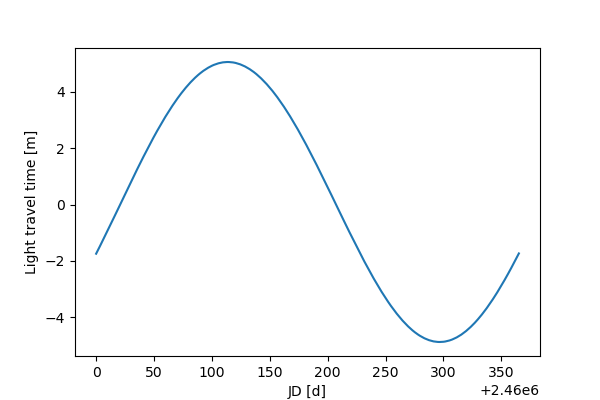

In [25]:
from astropy import coordinates as coord
from astropy import units as u

"""In realtà RA e DEC variano leggermente tra un frame e il successivo."""                       
# RA      = '17:49:12.93'        / Telescope RA (J2000.0)                         
# DEC     = '+29:52:48'          / Telescope DEC (J2000.0)
# SITELAT =           45.8485832 / [deg] Telescope latitude, N45:50:54.894        
# SITELONG=           11.5689993 / [deg] Telescope longitude, E11:34:08.397

# Carico le coordinate del nostro target
target = coord.SkyCoord("17:49:12.93","+29:52:48", unit=(u.hourangle, u.deg), frame='icrs')

from astropy.time import Time

# Calcolo il light travel time per un anno di osservazioni
jd_plot = np.arange(2460000, 2460365.25, 0.10) #Prendo un anno a intervalli di 0.1 giorni
# Prendo il vettore jd e lo converto in un vettore di tipo time che contiene anche la nostra location
tm_plot = Time(jd_plot, format='jd', scale='utc', location=('45.8485832d', '11.5689993d'))
# Calcola il light travel time per ciascun tempo contentuto in tm_plot, per il target selezionato
ltt_plot = tm_plot.light_travel_time(target, ephemeris='jpl')

# Converto il tm_plot in tdb e aggiungo il light travel time
bjd_tdb_plot = tm_plot.tdb + ltt_plot

plt.figure(figsize=(6,4))
plt.plot(jd_plot, ltt_plot.to_value(u.min))
plt.xlabel('JD [d]')
plt.ylabel('Light travel time [m]')
plt.show()


This plot shows the light time travel correction along one year, as the Earth position changes while it moves around the Sun, the light time travel correction changes accordingly.

Now we apply the correction to our observations instead of a fictitious jd array

In [26]:
""" array_jd contiene il tempo di inizio osservazione in secondi, noi vogliamo il tempo al centro
dell'osservazione in secondi quindi aggiungiamo metà del tempo di esposizione, dividendolo per 86400
in modo da avere secondi. """

jd = array_jd + (array_exptime/2)*(1/86400)

tm = Time(jd, format='jd', scale='utc', location=('45.8485832d', '11.5689993d'))

ltt_barycenter = tm.light_travel_time(target)

bjd_tdb = tm.tdb + ltt_barycenter

print('Average Light travel time:                     {0:12.2f} minutes'.format(np.average(ltt_barycenter.to_value(u.min))))
print('Average difference between JD_UTC and BJD_TDB: {0:12.2f} seconds'.format(np.average(jd - bjd_tdb.to_value('jd'))*86400))

Average Light travel time:                             3.54 minutes
Average difference between JD_UTC and BJD_TDB:      -281.66 seconds
